# Demo with esgf search for CMIP6 at DKRZ site and CMCC WPS

ESGF Node at DKRZ: https://esgf-data.dkrz.de/search/cmip6-dkrz/

## Use esgf search at DKRZ ... no distributed search



Using ``esgf-pyclient``: 
https://esgf-pyclient.readthedocs.io/en/latest/notebooks/examples/search.html

In [1]:
from pyesgf.search import SearchConnection
conn = SearchConnection('http://esgf-data.dkrz.de/esg-search',
                        distrib=False)

**Search only CMIP6 files available at CMCC**

In [2]:
ctx = conn.new_context(project='CMIP6', data_node='esgf-node2.cmcc.it', latest=True, replica=False)
ctx.hit_count

206740

Select only one dataset

In [3]:
results = ctx.search(
    institution_id='CMCC',
    source_id='CMCC-ESM2',
    experiment_id='1pctCO2-bgc', 
    variable='cLand', 
    frequency='mon',
    variant_label='r1i1p1f1'
)
len(results)

1

In [4]:
ds = results[0]
ds.json

{'id': 'CMIP6.C4MIP.CMCC.CMCC-ESM2.1pctCO2-bgc.r1i1p1f1.Emon.cLand.gn.v20210301|esgf-node2.cmcc.it',
 'version': '20210301',
 'access': ['HTTPServer', 'GridFTP', 'OPENDAP', 'Globus'],
 'activity_drs': ['C4MIP'],
 'activity_id': ['C4MIP'],
 'cf_standard_name': ['total_carbon_in_all_terrestrial_carbon_pools'],
 'citation_url': ['http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.C4MIP.CMCC.CMCC-ESM2.1pctCO2-bgc.r1i1p1f1.Emon.cLand.gn.v20210301.json'],
 'data_node': 'esgf-node2.cmcc.it',
 'data_specs_version': ['01.00.31'],
 'dataset_id_template_': ['%(mip_era)s.%(activity_drs)s.%(institution_id)s.%(source_id)s.%(experiment_id)s.%(member_id)s.%(table_id)s.%(variable_id)s.%(grid_label)s'],
 'datetime_start': '1850-01-16T12:00:00Z',
 'datetime_stop': '2014-12-16T12:00:00Z',
 'directory_format_template_': ['%(root)s/%(mip_era)s/%(activity_drs)s/%(institution_id)s/%(source_id)s/%(experiment_id)s/%(member_id)s/%(table_id)s/%(variable_id)s/%(grid_label)s/%(version)s'],
 'east_degrees': 358.75,
 'exp

Get a dataset identifier used by rook

In [5]:
dataset_id = ds.json['instance_id']
dataset_id

'CMIP6.C4MIP.CMCC.CMCC-ESM2.1pctCO2-bgc.r1i1p1f1.Emon.cLand.gn.v20210301'

Time range

In [6]:
f"{ds.json['datetime_start']}/{ds.json['datetime_stop']})"

'1850-01-16T12:00:00Z/2014-12-16T12:00:00Z)'

Bounding Box: (West, North, East, South)

In [7]:
f"({ds.json['west_degrees']}, {ds.json['north_degrees']},{ds.json['east_degrees']}, {ds.json['south_degrees']})"

'(0.0, 90.0,358.75, -90.0)'

Size in GB

In [8]:
f"{ds.json['size'] / 1024 / 1024 / 1024} GB"

'0.11361257266253233 GB'

## Use Rook to run subset, average_time or average

In [9]:
import os
# os.environ['ROOK_URL'] = 'https://ddshub.cmcc.it/wps'
os.environ['ROOK_URL'] = 'http://192.168.118.145:8182/wps'
os.environ['ROOK_MODE'] = 'async'
# os.environ['ROOKI_OUTPUT_DIR'] = <output_dir> # custom the output directory
os.environ['ROOKI_OUTPUT_DIR'] = '/home/vale/outs' 

from rooki import rooki

Use the following dds api-key for the CMCC WPS operations:

In [10]:
#api_key='8c7482c9-7163-4019-ac9d-73e6a84c1a49:S1fK3X9I2cgJbrSnXM1krO6zyz6P-uCuqejXXsbKL6k'
api_key='e1f21178-14dc-47c0-be72-203b97c1e344:c9diEIbi5iEGbN2FSgO-Mx9W4NlNZXlRQmUpStiDkgU'

Run subset

In [11]:
%%time
collection = dataset_id
resp = rooki.subset(
    collection=collection,
    time='1900-01-01/1910-02-02',
    area='-25,40,25,-40', #<west,north,east,south>
    api_key=api_key,
)
resp.ok

CPU times: user 20.2 ms, sys: 1.21 ms, total: 21.4 ms
Wall time: 24.1 s


True

Run average_time

In [12]:
%%time
collection = dataset_id
resp = rooki.average_time(
    collection=collection,
    freq='year',
    api_key=api_key,
)
resp.ok

CPU times: user 94 ms, sys: 1.46 ms, total: 95.4 ms
Wall time: 1min 57s


True

Run average

In [13]:
%%time
collection = dataset_id
resp = rooki.average(
    collection=collection,
    dims='time',
    api_key=api_key,
)
resp.ok

CPU times: user 21.5 ms, sys: 4.56 ms, total: 26 ms
Wall time: 24.1 s


True

Download and open with xarray

In [14]:
ds_0 = resp.datasets()[0]
ds_0

Metalink content-type detected.


<xarray.Dataset>
Dimensions:             (lat: 192, lon: 288, bnds: 2)
Coordinates:
  * lat                 (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon                 (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Dimensions without coordinates: bnds
Data variables:
    cLand               (lat, lon) float32 ...
    latitude_longitude  int64 ...
    lat_bnds            (lat, bnds) float64 ...
    lon_bnds            (lon, bnds) float64 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            cLand
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/fe397d18-645f-4f9a-a24c-76d0299dedb9

Run subset with time_components attribute

In [15]:
%%time
collection = dataset_id
resp = rooki.subset(
    collection=collection,
    time='2010-01-01/2010-04-05',
    time_components='year:2010|month:jan,feb',
    area='0.0,50.0,100,-50', #<west,north,east,south>
    api_key=api_key,
)
resp.ok

CPU times: user 15 ms, sys: 11 ms, total: 26 ms
Wall time: 24.1 s


True

Download and open with xarray

In [16]:
ds_1 = resp.datasets()[0]
ds_1

Metalink content-type detected.


<xarray.Dataset>
Dimensions:             (time: 2, lat: 106, lon: 81, bnds: 2)
Coordinates:
  * lon                 (lon) float64 0.0 1.25 2.5 3.75 ... 97.5 98.75 100.0
  * time                (time) datetime64[ns] 2010-01-16T12:00:00 2010-02-15
  * lat                 (lat) float64 -49.48 -48.53 -47.59 ... 47.59 48.53 49.48
Dimensions without coordinates: bnds
Data variables:
    cLand               (time, lat, lon) float32 ...
    latitude_longitude  int64 ...
    lon_bnds            (lon, bnds) float64 ...
    lat_bnds            (lat, bnds) float64 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            C4MIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            cLand
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/fe397d18-645f-4f9a-a24c-76d0299dedb9

### An example with another dataset...

In [17]:
results = ctx.search(
    institution_id='CMCC',
    source_id='CMCC-CM2-SR5',
    experiment_id='historical', 
    variable='clt', 
    frequency='3hr',
    variant_label='r10i1p2f1'
)
len(results)

1

In [18]:
ds1 = results[0]
dataset_id = ds1.json['instance_id']
print(f"Dataset id: {dataset_id}")
print(f"Time range : {ds1.json['datetime_start']}/{ds1.json['datetime_stop']}")
print(f"Bounding box: ({ds1.json['west_degrees']}, {ds1.json['north_degrees']},{ds1.json['east_degrees']}, {ds1.json['south_degrees']})")
print(f"Size: {ds.json['size'] / 1024 / 1024 / 1024} GB")

Dataset id: CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r10i1p2f1.3hr.clt.gn.v20220401
Time range : 1850-01-01T01:30:00Z/2014-12-31T22:30:00Z
Bounding box: (0.0, 90.0,358.75, -90.0)
Size: 0.11361257266253233 GB


Run subset

In [19]:
%%time
collection = dataset_id
resp = rooki.subset(
    collection=collection,
    time='2000-01-01T00:00/2002-01-01T00:00',
    time_components='year:2000|month:jan,feb|day:01,02,03,04',
    area='72.5,45.75,73.5,40.75', #<west,north,east,south>
    api_key=api_key,
)
resp.ok

CPU times: user 38.3 ms, sys: 2.49 ms, total: 40.8 ms
Wall time: 51.1 s


True

### The outputs are available as a Metalink document
https://github.com/metalink-dev

Metalink URL

In [20]:
resp.url

'http://192.168.118.145:8182/wps/outputs/9b27e62c-cf07-11ed-885e-0242ac110002/input.meta4'

Number of files

In [21]:
resp.num_files

1

Total size in MB

In [22]:
resp.size_in_mb

0.02964496612548828

Download URLs

In [23]:
resp.download_urls()

['http://192.168.118.145:8182/wps/outputs/b8bd8c00-cf07-11ed-885e-0242ac110002/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_r10i1p2f1_3hr_clt_gn_v20220401_20000101T00:00-20020101T00:00.nc']

Download and open with xarray

In [24]:
ds_2 = resp.datasets()[0]
ds_2

Metalink content-type detected.


<xarray.Dataset>
Dimensions:             (time: 64, lat: 6, lon: 1, bnds: 2)
Coordinates:
  * lat                 (lat) float64 40.99 41.94 42.88 43.82 44.76 45.71
  * lon                 (lon) float64 72.5
  * time                (time) datetime64[ns] 2000-01-01T01:30:00 ... 2000-02...
Dimensions without coordinates: bnds
Data variables:
    clt                 (time, lat, lon) float32 ...
    latitude_longitude  int64 ...
    lat_bnds            (lat, bnds) float64 ...
    lon_bnds            (lon, bnds) float64 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   27375.0
    branch_time_in_parent:  27375.0
    comment:                none
    ...                     ...
    title:                  CMCC-CM2-SR5 output prepared for CMIP6
    variable_id:            clt
    variant_label:          r10i1p2f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/b53909ef-a74c-4c69-b627-e95f6a635d3e

### Provenance

Provenance information is given using the *PROV* standard.
https://pypi.org/project/prov/

Provenance: URL to json document

In [25]:
resp.provenance()

'http://192.168.118.145:8182/wps/outputs/9b27e62c-cf07-11ed-885e-0242ac110002/provenance.json'

Provenance Plot

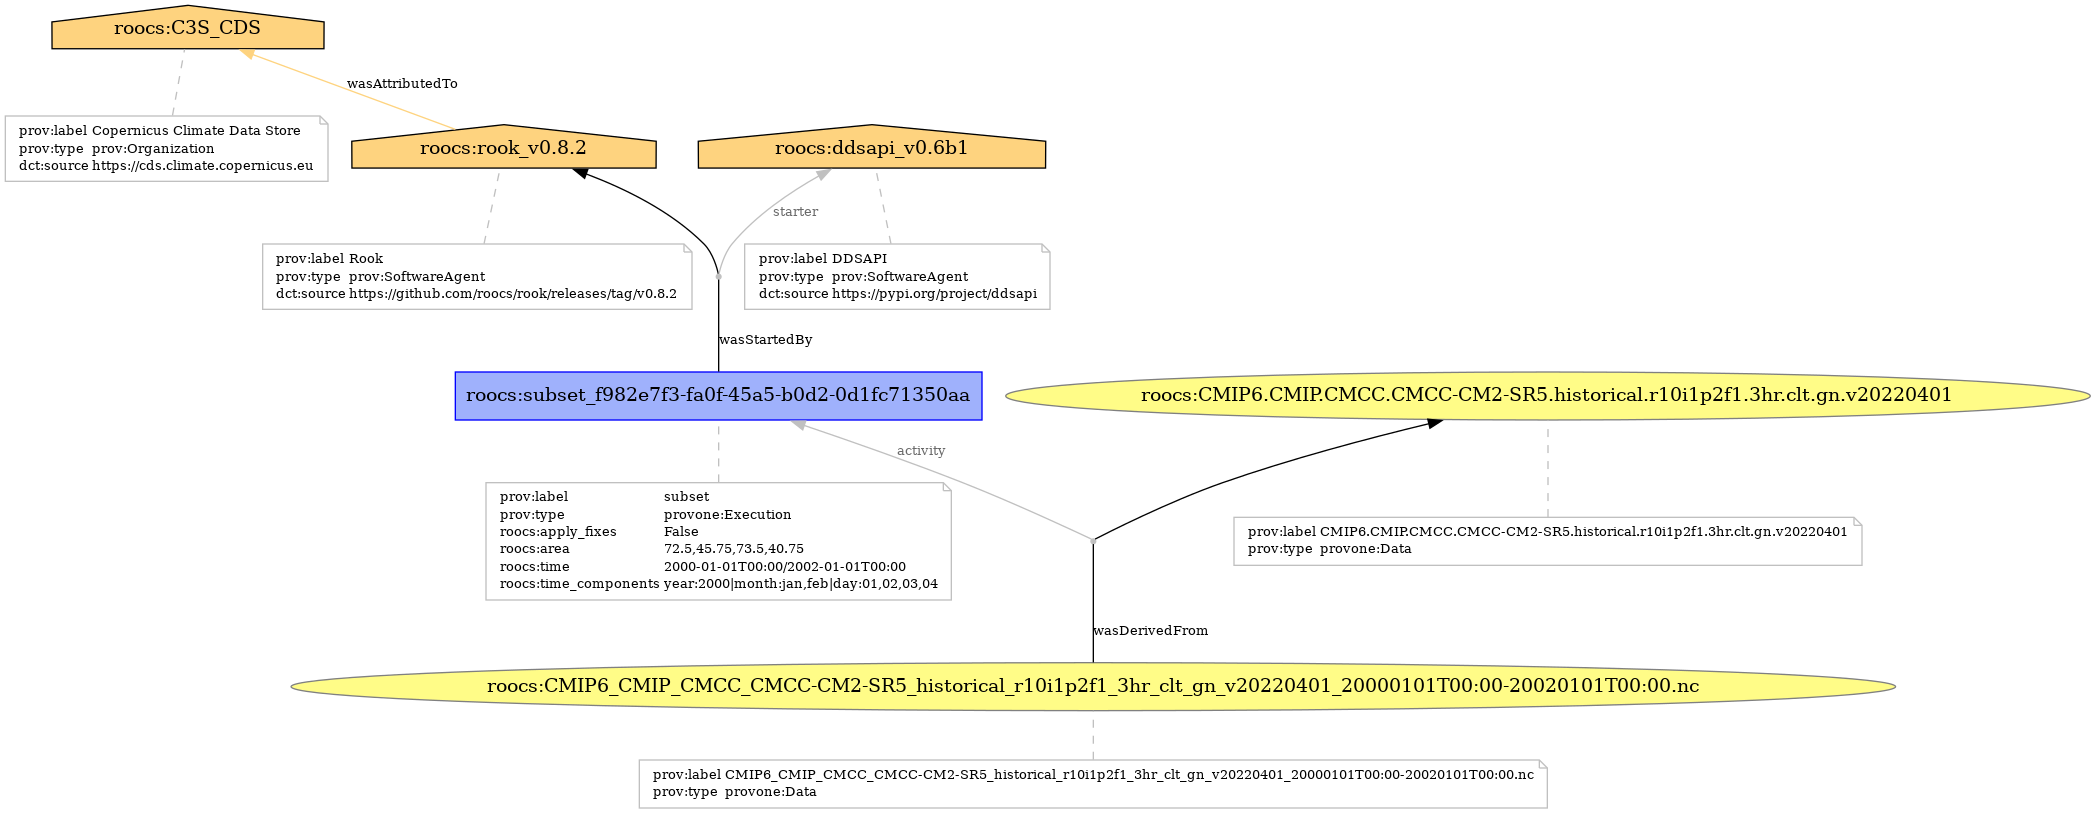

In [26]:
from IPython.display import Image
Image(resp.provenance_image())